{'buildings' -> 0, 

'forest' -> 1,

'glacier' -> 2,

'mountain' -> 3,

'sea' -> 4,

'street' -> 5 }

In [0]:
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.regularizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
home_dir = '/content/gdrive/My Drive/data-science-my-projects/AV-Intel-Scene-Classification-Challenge'
print(os.listdir(home_dir))

['scene-classification-cnn-vgg16-hybrid1365.ipynb', 'dataset', 'submissions', 'scene-classification-cnn-data-aug-vgg16.ipynb', 'models', 'scene-classification-cnn-data-aug-resnet50.ipynb', 'scene-classification-cnn-vgg16-places365.ipynb']


## Read and set up data

In [0]:
# Read data
dataset_dir = os.path.join(home_dir, "dataset")
train_dir = os.path.join(dataset_dir, "train")


train_df = pd.read_csv(dataset_dir + '/train.csv')
train_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


Image shape = (150, 150, 3)


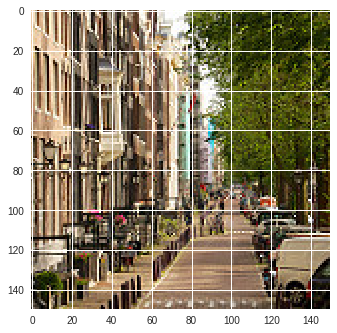

In [0]:
# Read and display an image
image = plt.imread(os.path.join(train_dir, os.listdir(train_dir)[100]))
print("Image shape =", image.shape)
train_input_shape = image.shape
plt.imshow(image)
plt.show()

In [0]:
# Distribution of classes
train_df.label.value_counts()/len(train_df.label)

3    0.178290
2    0.173594
5    0.169250
4    0.163438
1    0.161148
0    0.154280
Name: label, dtype: float64

In [0]:
# Number of unique classes
n_classes = len(train_df.label.unique())
print("Number of unique classes =", n_classes)

Number of unique classes = 6


## Image Augmentation

In [0]:
# Augment data
batch_size = 16
train_input_shape = (64, 64, 3)

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.3,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    y_col="label", 
                                                    class_mode="other",
                                                    subset="training",
                                                    target_size=train_input_shape[0:2], 
                                                    shuffle=True,
                                                    batch_size=batch_size)

valid_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    y_col="label", 
                                                    class_mode="other",
                                                    subset="validation",
                                                    target_size=train_input_shape[0:2], 
                                                    shuffle=True,
                                                    batch_size=batch_size)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 13628 images.
Found 3406 images.
Total number of batches = 851 and 212


## Build model

In [0]:
# Pre-trained weight downloaded from https://github.com/GKalliatakis/Keras-Application-Zoo/releases/download/0.1/vgg16-hybrid1365_weights_tf_dim_ordering_tf_kernels_notop.h5
model_dir = os.path.join(home_dir, "models")
WEIGHTS_PATH_NO_TOP = os.path.join(model_dir, "pretrained_vgg16-hybrid1365_weights_keras_notop.h5")
WEIGHTS_PATH_NO_TOP

'/content/gdrive/My Drive/data-science-my-projects/AV-Intel-Scene-Classification-Challenge/models/pretrained_vgg16-hybrid1365_weights_keras_notop.h5'

In [0]:
# Build the architecture

def VGG16_Places365(input_shape=None, classes=n_classes):
    """Build a VGGG16 model and load weights from pre-trained model of Places365 dataset """
  
    # Input
    img_input = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block1_conv1')(img_input)

    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block1_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool", padding='valid')(x)

    # Block 2
    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block2_conv1')(x)

    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block2_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool", padding='valid')(x)

    # Block 3
    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv1')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv2')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool", padding='valid')(x)

    # Block 4
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool", padding='valid')(x)

    # Block 5
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool", padding='valid')(x)
    
    # Create model.
    places_model = Model(img_input, x, name='vgg16-places365')
    
    # Load weights
    places_model.load_weights(WEIGHTS_PATH_NO_TOP)
    
    # Return the model
    return places_model
  

In [0]:
# Load pre-trained model
places_model = VGG16_Places365(input_shape=train_input_shape, classes=n_classes)

for layer in places_model.layers:
    layer.trainable = True

#places_model.summary()

In [0]:
# Add layers at the end
X = places_model.output
X = Flatten()(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=places_model.input, outputs=output)

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
___________________________

In [0]:
#MY_MODEL_WEIGHTS_PATH = os.path.join(model_dir, "hybrid1365_vgg16_weights.h5")
#model.load_weights(MY_MODEL_WEIGHTS_PATH)

In [0]:
#optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam(lr=1e-4)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_acc', patience=25, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, 
                              verbose=1, mode='auto')

In [0]:
%%time
n_epoch = 50

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[early_stop, reduce_lr],
                              use_multiprocessing=True,
                              workers=10
                             )

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/50
851/851 [==============================] - 122s 144ms/step - loss: 0.7608 - acc: 0.8109 - val_loss: 0.8967 - val_acc: 0.7659
Epoch 2/50
851/851 [==============================] - 121s 142ms/step - loss: 0.7428 - acc: 0.8220 - val_loss: 0.8058 - val_acc: 0.7886
Epoch 3/50
851/851 [==============================] - 122s 143ms/step - loss: 0.6915 - acc: 0.8398 - val_loss: 0.7715 - val_acc: 0.8172
Epoch 4/50
851/851 [==============================] - 122s 143ms/step - loss: 0.7037 - acc: 0.8448 - val_loss: 0.8128 - val_acc: 0.8154
Epoch 5/50
851/851 [==============================] - 122s 143ms/step - loss: 0.7067 - acc: 0.8411 - val_loss: 0.9129 - val_acc: 0.7594
Epoch 6/50
851/851 [==============================] - 122s 143ms/step - loss: 0.6341 - acc: 0.8664 - val_loss: 0.7690 - val_acc: 0.8140
Epoch 7/50
851/851 [==============================] - 122s 143ms/step - loss: 0.6468 - acc: 0.8583 - val_loss: 0.8116 - val_acc: 0.7907
Epoch 8/50
851/851 [============================

In [0]:
model_dir = os.path.join(home_dir, "models")
model.save(model_dir + '/hybrid1365_vgg16_model.h5')
model.save_weights(model_dir + '/hybrid1365_vgg16_weights.h5')

In [0]:
epoch_count = 0

In [0]:
if epoch_count == 0:
  acc_hist, val_acc_hist, loss_hist, val_loss_hist = [], [], [], []
  
epoch_count += 1

acc = (history.history['acc'])
acc_hist = acc_hist + acc[:len(acc)]

val_acc = (history.history['val_acc'])
val_acc_hist = val_acc_hist + val_acc[:len(val_acc)]

loss = (history.history['loss'])
loss_hist = loss_hist + loss[:len(loss)]

val_loss = (history.history['val_loss'])
val_loss_hist = val_loss_hist + val_loss[:len(val_loss)]

epochs = range(len(acc_hist))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
axes[0].plot(epochs, acc_hist, 'r-', label='Training Accuracy')
axes[0].plot(epochs, val_acc_hist, 'b--', label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend(loc='best')

axes[1].plot(epochs, loss_hist, 'r-', label='Training Loss')
axes[1].plot(epochs, val_loss_hist, 'b--', label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend(loc='best')

plt.show()

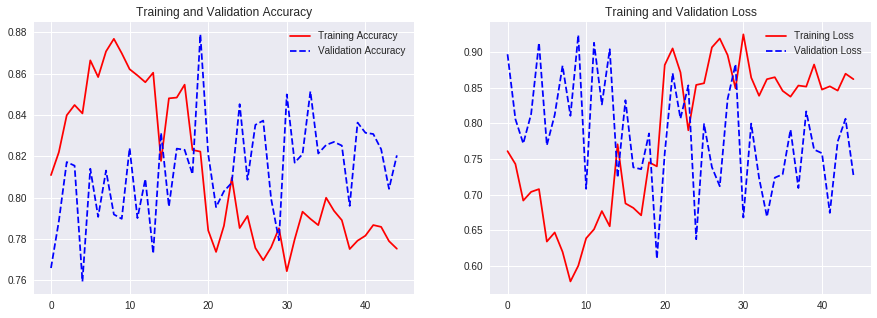

In [0]:
# Plot the training graph
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [0]:
# Evaluate on validation set
result = model.evaluate_generator(generator=valid_generator, verbose=1, steps=STEP_SIZE_VALID)
result

212/212 [==============================] - 24s 115ms/step


[0.7996667413233304, 0.8126843657465459]

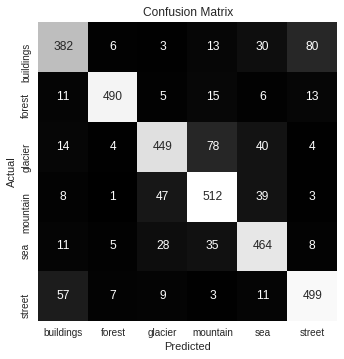

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       514
           1       0.96      0.91      0.93       540
           2       0.83      0.76      0.79       589
           3       0.78      0.84      0.81       610
           4       0.79      0.84      0.81       551
           5       0.82      0.85      0.84       586

   micro avg       0.82      0.82      0.82      3390
   macro avg       0.83      0.82      0.83      3390
weighted avg       0.83      0.82      0.82      3390



In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    #y_pred = np.asarray(y_pred).astype('float32').ravel()
    #y_pred = y_pred >= 0.5
    #y_pred = y_pred.astype('int').ravel()
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5])
    sns.heatmap(conf_matrix, annot=True, fmt="d", square=True, cbar=False, 
                cmap=plt.cm.gray, xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred))
    #print("\nAUC: ", roc_auc_score(y_true, y_pred, average='micro'))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

## Prepare data for prediction on test set

In [0]:
test_df = pd.read_csv(dataset_dir + "/test_WyRytb0.csv")
test_df.shape

(7301, 1)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    #y_col="label", 
                                                    class_mode=None,
                                                    target_size=train_input_shape[0:2], 
                                                    batch_size=1,
                                                    shuffle=False
                                                 )

Found 7301 images.


## Predict and Submit

In [0]:
# Predict on test data
test_generator.reset()
predictions = model.predict_generator(test_generator,verbose=1, steps=len(test_generator))
predictions = np.argmax(predictions, axis=1)
#predictions = predictions.astype('int').ravel()
predictions.shape

7301/7301 [==============================] - 2314s 317ms/step


(7301,)

In [0]:
# Retrieve filenames
import re
#test_img_ids = [re.split("/", val)[1] for val in test_generator.filenames]
test_img_ids = test_generator.filenames
len(test_img_ids)

7301

In [0]:
# Create dataframe for submission
submission_df = pd.DataFrame({'image_name' : test_img_ids,
                              'label' : predictions })
submission_df.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,0
4,14.jpg,5


In [0]:
# Create submission file
submission_dir = os.path.join(home_dir, "submissions")
submission_df.to_csv(submission_dir + '/submission_hybrid1365_vgg16_2.csv', index=False)